# Credit Market Data Exploration

This notebook explores the credit market data used for training deep reinforcement learning agents. We'll analyze:

1. **Data Structure** - Understanding the multi-asset dataset
2. **Credit Spreads** - Investment grade vs high yield dynamics
3. **Cross-Asset Relationships** - Correlations with treasuries and equity volatility
4. **Temporal Patterns** - Trends, seasonality, and regime changes
5. **Feature Engineering** - Technical indicators and credit-specific metrics
6. **Data Quality** - Missing values, outliers, and preprocessing needs

**Dataset Coverage:**
- Investment Grade Credit ETFs (LQD, VCIT, VCSH, VCLT, IGLB)
- High Yield Credit ETFs (HYG, JNK, SHYG, SJNK, USHY)
- Treasury Benchmarks (SHY, IEF, TLT, etc.)
- Equity Volatility (VXX, VIXY, SPY, QQQ)
- Market Regime Indicators (VIX, TNX, etc.)

In [59]:
# Import required libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path to import project modules
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Project modules
from data.loader import DataManager
from utils.risk_metrics import RiskMetrics
from utils.volatility_models import EWMAVolatility, GARCHVolatility

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.options.display.float_format = '{:.4f}'.format

print("✓ All libraries imported successfully")
print(f"Project root: {project_root}")

✓ All libraries imported successfully
Project root: c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets


## 1. Load and Initialize Data

We'll use the `DataManager` class to handle data loading, which:
- Downloads historical data from Yahoo Finance
- Caches data in ArcticDB for fast retrieval
- Handles multiple asset classes (credit, treasuries, equities, volatility)

In [60]:
# Initialize DataManager with base configuration
config_path = project_root / "configs" / "base.yaml"
dm = DataManager(config_path=str(config_path))

# Display available tickers
print(f"Total tickers to download: {len(dm.tickers)}")
print(f"\nTicker list: {', '.join(dm.tickers)}")

# Download data (this will use cache if available)
# Using last 3 years for exploration
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

print(f"\nDownloading data from {start_date.date()} to {end_date.date()}...")
raw_data = dm.download_raw_data(
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d'),
    force_download=False  # Use cache if available
)

print(f"\n✓ Data loaded successfully!")
print(f"Shape: {raw_data.shape}")
print(f"Date range: {raw_data.index[0]} to {raw_data.index[-1]}")
print(f"Total trading days: {len(raw_data)}")

INFO:data.loader:Configuration loaded from c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\configs\base.yaml


INFO:data.loader:ArcticDB initialized at C:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\notebooks\data\arctic_db/credit_market_data
INFO:data.loader:DataManager initialized with 27 tickers
INFO:data.loader:Downloading data for 27 tickers from 2022-12-12 to 2025-12-11
INFO:data.loader:Loaded raw_data from ArcticDB with shape (754, 162)
INFO:data.loader:Loaded data from ArcticDB cache


Total tickers to download: 27

Ticker list: SJNK, ^MOVE, QQQ, VCIT, VIXY, VGSH, JNK, VGLT, SPY, DX-Y.NYB, IEF, LQD, HYG, TLT, VXX, SHYG, USHY, TLH, ^TNX, IGLB, VGIT, VCSH, ^VIX, IEI, VCLT, SHY, ^IRX


✓ Data loaded successfully!
Shape: (754, 162)
Date range: 2022-12-12 00:00:00 to 2025-12-10 00:00:00
Total trading days: 754


## 2. Data Structure Overview

Let's examine the structure of our multi-asset dataset and understand what data we have for each ticker.

In [61]:
# Display first few rows
print("First 5 rows of raw data:")
print(raw_data.head())

# Check column structure (multi-index if multiple tickers)
print(f"\n\nColumn structure:")
if isinstance(raw_data.columns, pd.MultiIndex):
    print(f"MultiIndex levels: {raw_data.columns.names}")
    for level in range(raw_data.columns.nlevels):
        print(f"Level {level} ({raw_data.columns.names[level]}): {raw_data.columns.get_level_values(level).unique().tolist()[:10]}...")  # First 10 values
else:
    print(f"Columns: {raw_data.columns.tolist()}")

# Data completeness by ticker
print("\n\nData completeness by ticker:")
if isinstance(raw_data.columns, pd.MultiIndex):
    # Extract close prices - use level index 1 (the second level with 'Open', 'High', 'Low', 'Close', etc.)
    close_prices = raw_data.xs('Close', level=1, axis=1)
    completeness = (1 - close_prices.isnull().sum() / len(close_prices)) * 100
    completeness_df = pd.DataFrame({
        'Ticker': completeness.index,
        'Completeness (%)': completeness.values
    }).sort_values('Completeness (%)', ascending=False)
    print(completeness_df.to_string(index=False))
else:
    print(f"Missing values: {raw_data.isnull().sum().sum()}")

First 5 rows of raw data:
              ^MOVE                                                 JNK  \
               Open     High      Low    Close Adj Close Volume    Open   
Date                                                                      
2022-12-12 132.7900 141.9300 132.7900 141.9300  141.9300 0.0000 92.1000   
2022-12-13 141.9300 141.9300 135.0800 135.0800  135.0800 0.0000 93.6300   
2022-12-14 135.0800 135.0800 120.2600 120.2600  120.2600 0.0000 93.2200   
2022-12-15 120.2600 120.2600 111.2600 111.2600  111.2600 0.0000 92.3100   
2022-12-16 111.2600 113.6500 111.2600 113.6500  113.6500 0.0000 91.8700   

                                    ...    VCLT                    \
              High     Low   Close  ...     Low   Close Adj Close   
Date                                ...                             
2022-12-12 92.2800 91.9200 92.1800  ... 79.8000 79.9900   68.6052   
2022-12-13 93.8700 92.6200 93.1800  ... 80.5600 80.7900   69.2913   
2022-12-14 93.2900 92.0700 9

## 3. Credit Spreads Analysis

Credit spreads are the yield difference between corporate bonds and risk-free treasuries. We'll analyze the spread dynamics for both investment grade (IG) and high yield (HY) credit.

In [62]:
# Extract closing prices
if isinstance(raw_data.columns, pd.MultiIndex):
    # Use level index 1 (second level) to extract 'Close' prices
    close_prices = raw_data.xs('Close', level=1, axis=1).copy()
else:
    close_prices = raw_data.copy()

# Calculate returns
returns = close_prices.pct_change().dropna()

# Define asset groups
ig_etfs = ['LQD', 'VCIT', 'VCSH', 'VCLT', 'IGLB']
hy_etfs = ['HYG', 'JNK', 'SHYG', 'SJNK', 'USHY']
treasury_etfs = ['SHY', 'IEF', 'TLT', 'VGSH', 'VGIT', 'VGLT', 'TLH']

# Create composite indices (equal-weighted average)
ig_available = [t for t in ig_etfs if t in close_prices.columns]
hy_available = [t for t in hy_etfs if t in close_prices.columns]
tsy_available = [t for t in treasury_etfs if t in close_prices.columns]

if ig_available:
    close_prices['IG_Composite'] = close_prices[ig_available].mean(axis=1)
if hy_available:
    close_prices['HY_Composite'] = close_prices[hy_available].mean(axis=1)
if tsy_available:
    close_prices['TSY_Composite'] = close_prices[tsy_available].mean(axis=1)

# Plot composite price evolution
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Investment Grade Credit', 'High Yield Credit', 'Treasury Benchmark'),
    vertical_spacing=0.08,
    shared_xaxes=True
)

if 'IG_Composite' in close_prices.columns:
    # Normalize to 100 at start
    ig_norm = (close_prices['IG_Composite'] / close_prices['IG_Composite'].iloc[0]) * 100
    fig.add_trace(go.Scatter(x=ig_norm.index, y=ig_norm.values, 
                            name='IG Credit', line=dict(color='blue')), row=1, col=1)

if 'HY_Composite' in close_prices.columns:
    hy_norm = (close_prices['HY_Composite'] / close_prices['HY_Composite'].iloc[0]) * 100
    fig.add_trace(go.Scatter(x=hy_norm.index, y=hy_norm.values,
                            name='HY Credit', line=dict(color='red')), row=2, col=1)

if 'TSY_Composite' in close_prices.columns:
    tsy_norm = (close_prices['TSY_Composite'] / close_prices['TSY_Composite'].iloc[0]) * 100
    fig.add_trace(go.Scatter(x=tsy_norm.index, y=tsy_norm.values,
                            name='Treasuries', line=dict(color='green')), row=3, col=1)

fig.update_layout(
    height=800,
    title_text="Credit and Treasury Price Evolution (Normalized to 100)",
    showlegend=False
)
fig.update_yaxes(title_text="Normalized Price", row=1, col=1)
fig.update_yaxes(title_text="Normalized Price", row=2, col=1)
fig.update_yaxes(title_text="Normalized Price", row=3, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)

fig.show()

# Save figure
fig_dir = project_root / 'data' / 'processed' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
fig.write_html(fig_dir / '01_credit_spreads.html')
try:
    fig.write_image(fig_dir / '01_credit_spreads.png', width=1200, height=800)
except Exception as e:
    print(f"Note: Could not save PNG (install kaleido: pip install kaleido)")

print("\n✓ Composite indices created and plotted")
print(f"✓ Figure saved to {fig_dir / '01_credit_spreads.html'}")

Note: Could not save PNG (install kaleido: pip install kaleido)

✓ Composite indices created and plotted
✓ Figure saved to c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\data\processed\figures\01_credit_spreads.html


## 4. Returns Distribution Analysis

Understanding return distributions is critical for risk management. We'll analyze:
- Summary statistics (mean, volatility, skewness, kurtosis)
- Distribution shapes and tail risks
- Comparison across asset classes

In [63]:
# Calculate comprehensive statistics for each asset
from scipy import stats

stats_dict = {
    'Mean (Ann.)': [],
    'Volatility (Ann.)': [],
    'Sharpe Ratio': [],
    'Skewness': [],
    'Kurtosis': [],
    'Min Return': [],
    'Max Return': [],
    'VaR (95%)': [],
    'CVaR (95%)': []
}

asset_names = []

# Select key assets for detailed analysis
key_assets = []
if 'IG_Composite' in close_prices.columns:
    key_assets.append('IG_Composite')
if 'HY_Composite' in close_prices.columns:
    key_assets.append('HY_Composite')
if 'TSY_Composite' in close_prices.columns:
    key_assets.append('TSY_Composite')

# Add individual tickers
for ticker in ['LQD', 'HYG', 'TLT', 'SPY', 'VXX']:
    if ticker in close_prices.columns:
        key_assets.append(ticker)

# Calculate statistics
for asset in key_assets:
    if asset in close_prices.columns:
        asset_returns = close_prices[asset].pct_change().dropna()
        
        asset_names.append(asset)
        stats_dict['Mean (Ann.)'].append(asset_returns.mean() * 252 * 100)
        stats_dict['Volatility (Ann.)'].append(asset_returns.std() * np.sqrt(252) * 100)
        
        # Sharpe ratio (assuming 0% risk-free rate for simplicity)
        sharpe = (asset_returns.mean() * 252) / (asset_returns.std() * np.sqrt(252))
        stats_dict['Sharpe Ratio'].append(sharpe)
        
        stats_dict['Skewness'].append(stats.skew(asset_returns))
        stats_dict['Kurtosis'].append(stats.kurtosis(asset_returns))
        stats_dict['Min Return'].append(asset_returns.min() * 100)
        stats_dict['Max Return'].append(asset_returns.max() * 100)
        
        # Risk metrics
        var_95 = RiskMetrics.value_at_risk(asset_returns, confidence_level=0.95)
        cvar_95 = RiskMetrics.conditional_var(asset_returns, confidence_level=0.95)
        stats_dict['VaR (95%)'].append(var_95 * 100)
        stats_dict['CVaR (95%)'].append(cvar_95 * 100)

# Create summary DataFrame
stats_df = pd.DataFrame(stats_dict, index=asset_names)
print("Summary Statistics (Annualized where applicable):")
print(stats_df.round(3))

# Highlight key insights
print("\n\nKey Observations:")
print(f"• Highest Volatility: {stats_df['Volatility (Ann.)'].idxmax()} ({stats_df['Volatility (Ann.)'].max():.2f}%)")
print(f"• Best Sharpe Ratio: {stats_df['Sharpe Ratio'].idxmax()} ({stats_df['Sharpe Ratio'].max():.3f})")
print(f"• Most Negative Skew: {stats_df['Skewness'].idxmin()} ({stats_df['Skewness'].min():.3f})")
print(f"• Highest Kurtosis (fat tails): {stats_df['Kurtosis'].idxmax()} ({stats_df['Kurtosis'].max():.3f})")

Summary Statistics (Annualized where applicable):
               Mean (Ann.)  Volatility (Ann.)  Sharpe Ratio  Skewness  \
IG_Composite        0.9110             7.7710        0.1170   -0.1680   
HY_Composite        1.9960             6.1410        0.3250    0.1700   
TSY_Composite      -1.7910             8.5810       -0.2090   -0.0110   
LQD                 1.0220             8.0940        0.1260   -0.1730   
HYG                 2.5200             6.3700        0.3960    0.1830   
TLT                -5.1600            15.2400       -0.3390   -0.0620   
SPY                19.4220            15.5370        1.2500    0.8630   
VXX               -46.4390            69.9300       -0.6640    1.7780   

               Kurtosis  Min Return  Max Return  VaR (95%)  CVaR (95%)  
IG_Composite     0.9630     -1.8800      1.6640     0.8640      1.1220  
HY_Composite     4.5520     -1.6400      2.6640     0.6200      0.8780  
TSY_Composite    0.4530     -1.7960      2.1230     0.9330      1.1770  


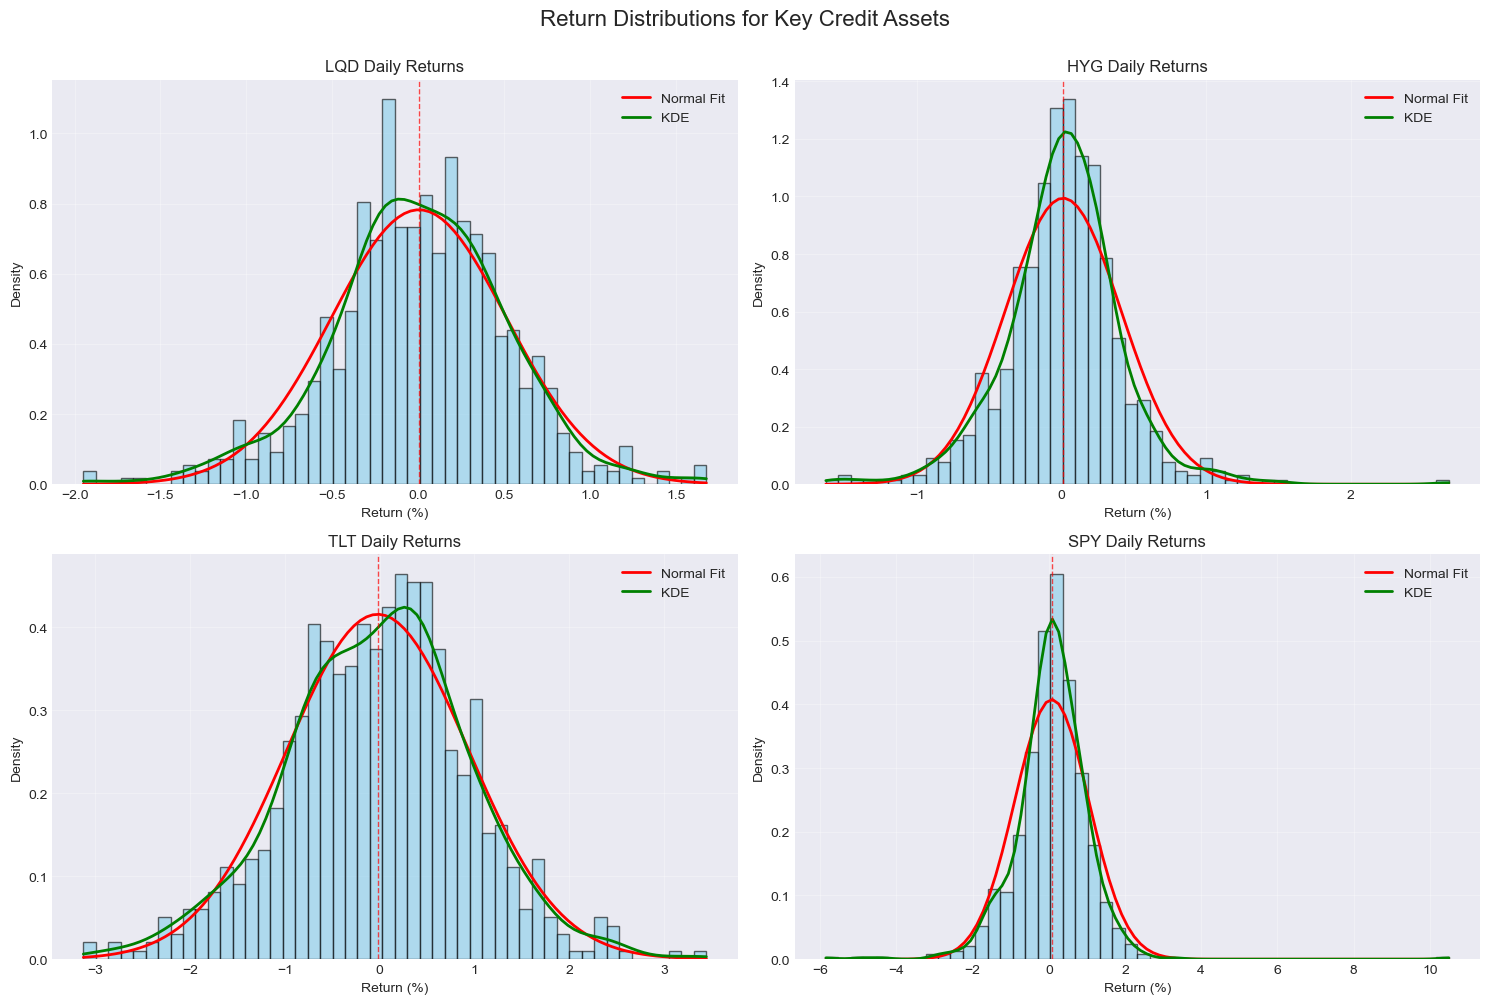

✓ Distribution plots generated
✓ Figure saved to c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\data\processed\figures\02_return_distributions.png


In [64]:
# Plot return distributions for key assets
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Return Distributions for Key Credit Assets', fontsize=16, y=1.00)

plot_assets = ['LQD', 'HYG', 'TLT', 'SPY'] if all(a in close_prices.columns for a in ['LQD', 'HYG', 'TLT', 'SPY']) else key_assets[:4]

for idx, asset in enumerate(plot_assets):
    if asset in close_prices.columns:
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        asset_returns = close_prices[asset].pct_change().dropna() * 100  # Convert to percentage
        
        # Histogram with KDE
        ax.hist(asset_returns, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')
        
        # Fit normal distribution
        mu, sigma = asset_returns.mean(), asset_returns.std()
        x = np.linspace(asset_returns.min(), asset_returns.max(), 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Fit')
        
        # Add KDE
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(asset_returns)
        ax.plot(x, kde(x), 'g-', linewidth=2, label='KDE')
        
        ax.set_title(f'{asset} Daily Returns')
        ax.set_xlabel('Return (%)')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add vertical line at mean
        ax.axvline(mu, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()

# Save figure
fig_dir = project_root / 'data' / 'processed' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / '02_return_distributions.png', dpi=300, bbox_inches='tight')

plt.show()

print("✓ Distribution plots generated")
print(f"✓ Figure saved to {fig_dir / '02_return_distributions.png'}")

## 5. Cross-Asset Correlation Analysis

Credit spreads don't trade in isolation. We'll examine correlations with:
- Treasuries (flight-to-quality dynamics)
- Equity markets (risk appetite)
- Volatility indices (fear gauge)

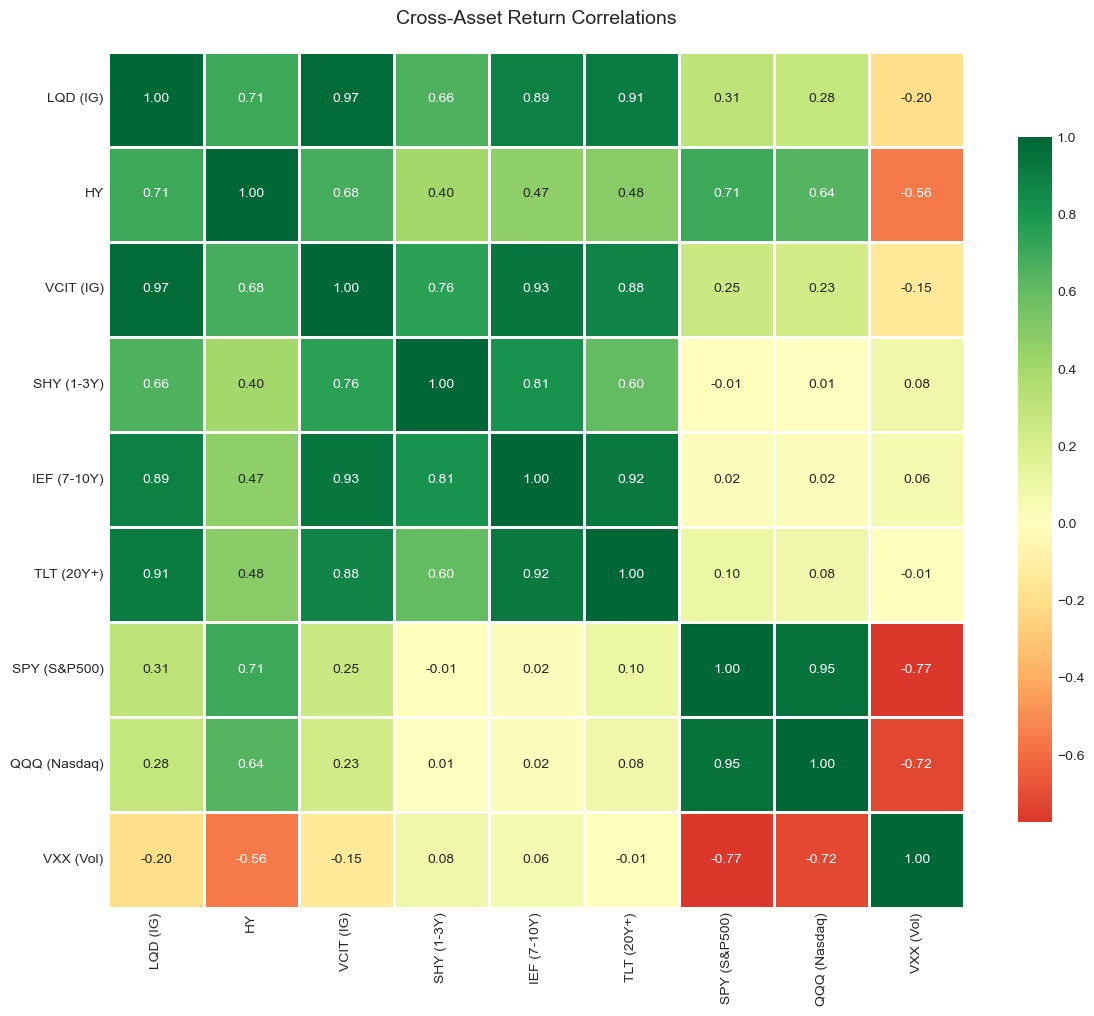


✓ Figure saved to c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\data\processed\figures\03_correlation_matrix.png

Key Correlation Insights:
• IG-HY Correlation: 0.705 (High correlation indicates credit as unified asset class)
• HY-Equity Correlation: 0.705 (HY behaves more equity-like)
• HY-Treasury Correlation: 0.483 (Negative = flight-to-quality effect)
• Assets most negatively correlated with VXX: {'SPY': -0.7727902989122176, 'QQQ': -0.7190783932652572, 'HYG': -0.5561827566976157}


In [65]:
# Calculate return correlations
returns_all = close_prices.pct_change().dropna()

# Select subset of assets for correlation matrix
corr_assets = []
asset_labels = []

# Credit assets
for ticker, label in [('LQD', 'LQD (IG)'), ('HYG', 'HY'), ('VCIT', 'VCIT (IG)')]:
    if ticker in returns_all.columns:
        corr_assets.append(ticker)
        asset_labels.append(label)

# Treasuries
for ticker, label in [('SHY', 'SHY (1-3Y)'), ('IEF', 'IEF (7-10Y)'), ('TLT', 'TLT (20Y+)')]:
    if ticker in returns_all.columns:
        corr_assets.append(ticker)
        asset_labels.append(label)

# Equities and volatility
for ticker, label in [('SPY', 'SPY (S&P500)'), ('QQQ', 'QQQ (Nasdaq)'), ('VXX', 'VXX (Vol)')]:
    if ticker in returns_all.columns:
        corr_assets.append(ticker)
        asset_labels.append(label)

if corr_assets:
    corr_matrix = returns_all[corr_assets].corr()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                xticklabels=asset_labels, yticklabels=asset_labels, ax=ax)
    ax.set_title('Cross-Asset Return Correlations', fontsize=14, pad=20)
    plt.tight_layout()
    
    # Save figure
    fig_dir = project_root / 'data' / 'processed' / 'figures'
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(fig_dir / '03_correlation_matrix.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    print(f"\n✓ Figure saved to {fig_dir / '03_correlation_matrix.png'}")
    
    print("\nKey Correlation Insights:")
    
    # IG vs HY correlation
    if 'LQD' in corr_assets and 'HYG' in corr_assets:
        ig_hy_corr = corr_matrix.loc['LQD', 'HYG']
        print(f"• IG-HY Correlation: {ig_hy_corr:.3f} (High correlation indicates credit as unified asset class)")
    
    # Credit vs Equity correlation
    if 'HYG' in corr_assets and 'SPY' in corr_assets:
        hy_spy_corr = corr_matrix.loc['HYG', 'SPY']
        print(f"• HY-Equity Correlation: {hy_spy_corr:.3f} (HY behaves more equity-like)")
    
    # Credit vs Treasury correlation (flight-to-quality)
    if 'HYG' in corr_assets and 'TLT' in corr_assets:
        hy_tlt_corr = corr_matrix.loc['HYG', 'TLT']
        print(f"• HY-Treasury Correlation: {hy_tlt_corr:.3f} (Negative = flight-to-quality effect)")
    

    # Volatility relationships    print("Insufficient assets for correlation analysis")

    if 'VXX' in corr_assets:

        vxx_corrs = corr_matrix.loc['VXX'].drop('VXX').sort_values()
        print(f"• Assets most negatively correlated with VXX: {vxx_corrs.head(3).to_dict()}")

## 6. Volatility Dynamics

Volatility is a crucial risk factor for credit markets. We'll analyze:
- Time-varying volatility patterns
- GARCH effects (volatility clustering)
- Comparison of volatility models

📊 Calculating volatility dynamics...


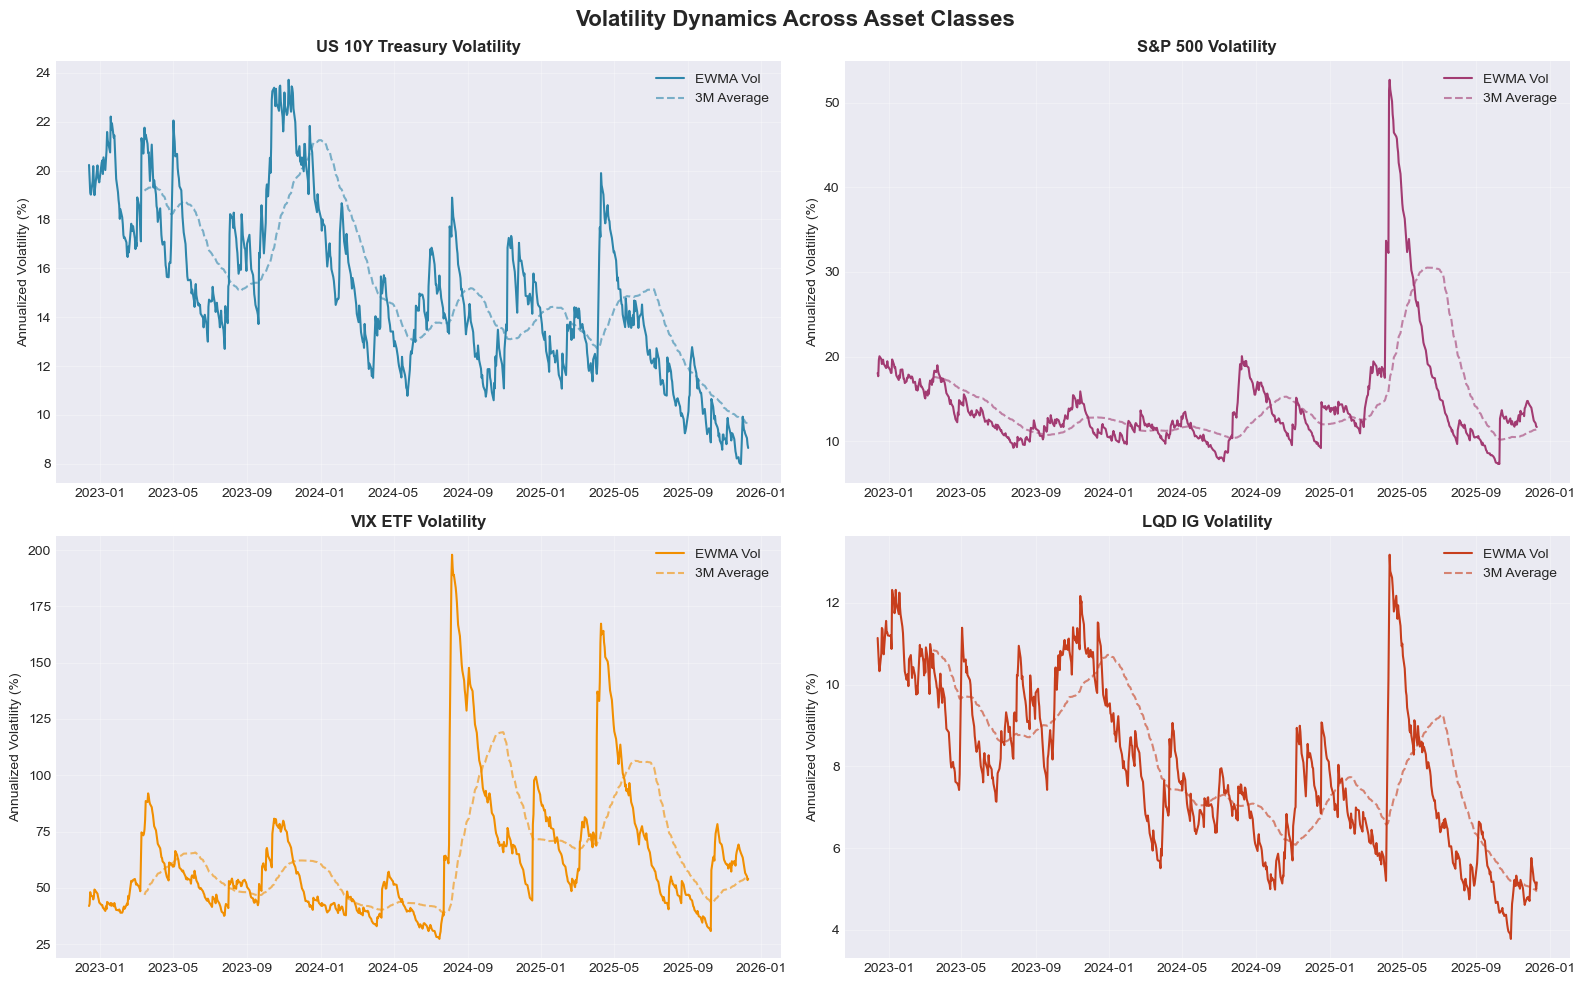


✓ Figure saved to c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\data\processed\figures\04_volatility_dynamics.png

📈 Volatility Statistics (Annualized %):
          Asset  Current    Mean     Std     Min      Max
US 10Y Treasury   8.6500 15.0600  3.5100  7.9900  23.7100
        S&P 500  11.6800 14.3700  6.3400  7.3100  52.6900
        VIX ETF  54.0100 63.2500 29.4300 27.3500 197.9200
         LQD IG   5.1600  7.9600  2.0200  3.7800  13.1700


In [66]:
# Calculate volatility using EWMA method
print("📊 Calculating volatility dynamics...")

# Select key assets for volatility analysis
vol_assets = []
vol_labels = []

# Add composites if they exist
if 'IG_Composite' in returns.columns:
    vol_assets.append('IG_Composite')
    vol_labels.append('IG Credit')
if 'HY_Composite' in returns.columns:
    vol_assets.append('HY_Composite')
    vol_labels.append('HY Credit')

# Add individual tickers
for ticker, label in [('TLT', 'US 10Y Treasury'), ('SPY', 'S&P 500'), ('VXX', 'VIX ETF'), ('LQD', 'LQD IG')]:
    if ticker in returns.columns and ticker not in vol_assets:
        vol_assets.append(ticker)
        vol_labels.append(label)

# Use first 4 available assets
vol_assets = vol_assets[:4]
vol_labels = vol_labels[:4]

if len(vol_assets) > 0:
    # Calculate EWMA volatility for selected assets
    ewma_vol = pd.DataFrame(index=returns.index)
    
    for asset in vol_assets:
        # Initialize EWMA volatility model
        ewma_model = EWMAVolatility(lambda_param=0.94)
        
        # Fit the model to returns data (already in decimal format)
        ewma_model.fit(returns[asset])
        
        # Get volatility series and annualize
        ewma_vol[asset] = ewma_model.volatility_series * np.sqrt(252)
    
    # Create visualization with dynamic layout
    n_assets = len(vol_assets)
    if n_assets == 1:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        axes = [axes]
    elif n_assets == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        axes = axes.flatten()
    elif n_assets == 3:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        axes = axes.flatten()
        axes[-1].set_visible(False)  # Hide the 4th subplot
    else:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        axes = axes.flatten()
    
    fig.suptitle('Volatility Dynamics Across Asset Classes', fontsize=16, fontweight='bold')
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    
    for idx, (asset, label, color) in enumerate(zip(vol_assets, vol_labels, colors)):
        ax = axes[idx]
        
        # Plot volatility
        ax.plot(ewma_vol.index, ewma_vol[asset] * 100, label='EWMA Vol', color=color, linewidth=1.5)
        
        # Add rolling mean
        rolling_mean = ewma_vol[asset].rolling(window=63).mean() * 100  # ~3 months
        ax.plot(ewma_vol.index, rolling_mean, label='3M Average', 
                color=color, linestyle='--', alpha=0.6)
        
        ax.set_title(f'{label} Volatility', fontweight='bold')
        ax.set_ylabel('Annualized Volatility (%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    fig_dir = project_root / 'data' / 'processed' / 'figures'
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(fig_dir / '04_volatility_dynamics.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    print(f"\n✓ Figure saved to {fig_dir / '04_volatility_dynamics.png'}")
    
    # Print volatility statistics
    print("\n📈 Volatility Statistics (Annualized %):")
    vol_stats = pd.DataFrame({
        'Asset': vol_labels,
        'Current': (ewma_vol.iloc[-1] * 100).values,
        'Mean': (ewma_vol.mean() * 100).values,
        'Std': (ewma_vol.std() * 100).values,
        'Min': (ewma_vol.min() * 100).values,
        'Max': (ewma_vol.max() * 100).values
    })
    print(vol_stats.round(2).to_string(index=False))
else:
    print("⚠️ No suitable assets found for volatility analysis")

## 7. Rolling Correlations (Regime Changes)

Correlations are not constant over time. We'll examine how relationships between assets evolve, which is critical for:
- Portfolio diversification
- Regime detection
- Dynamic hedging strategies

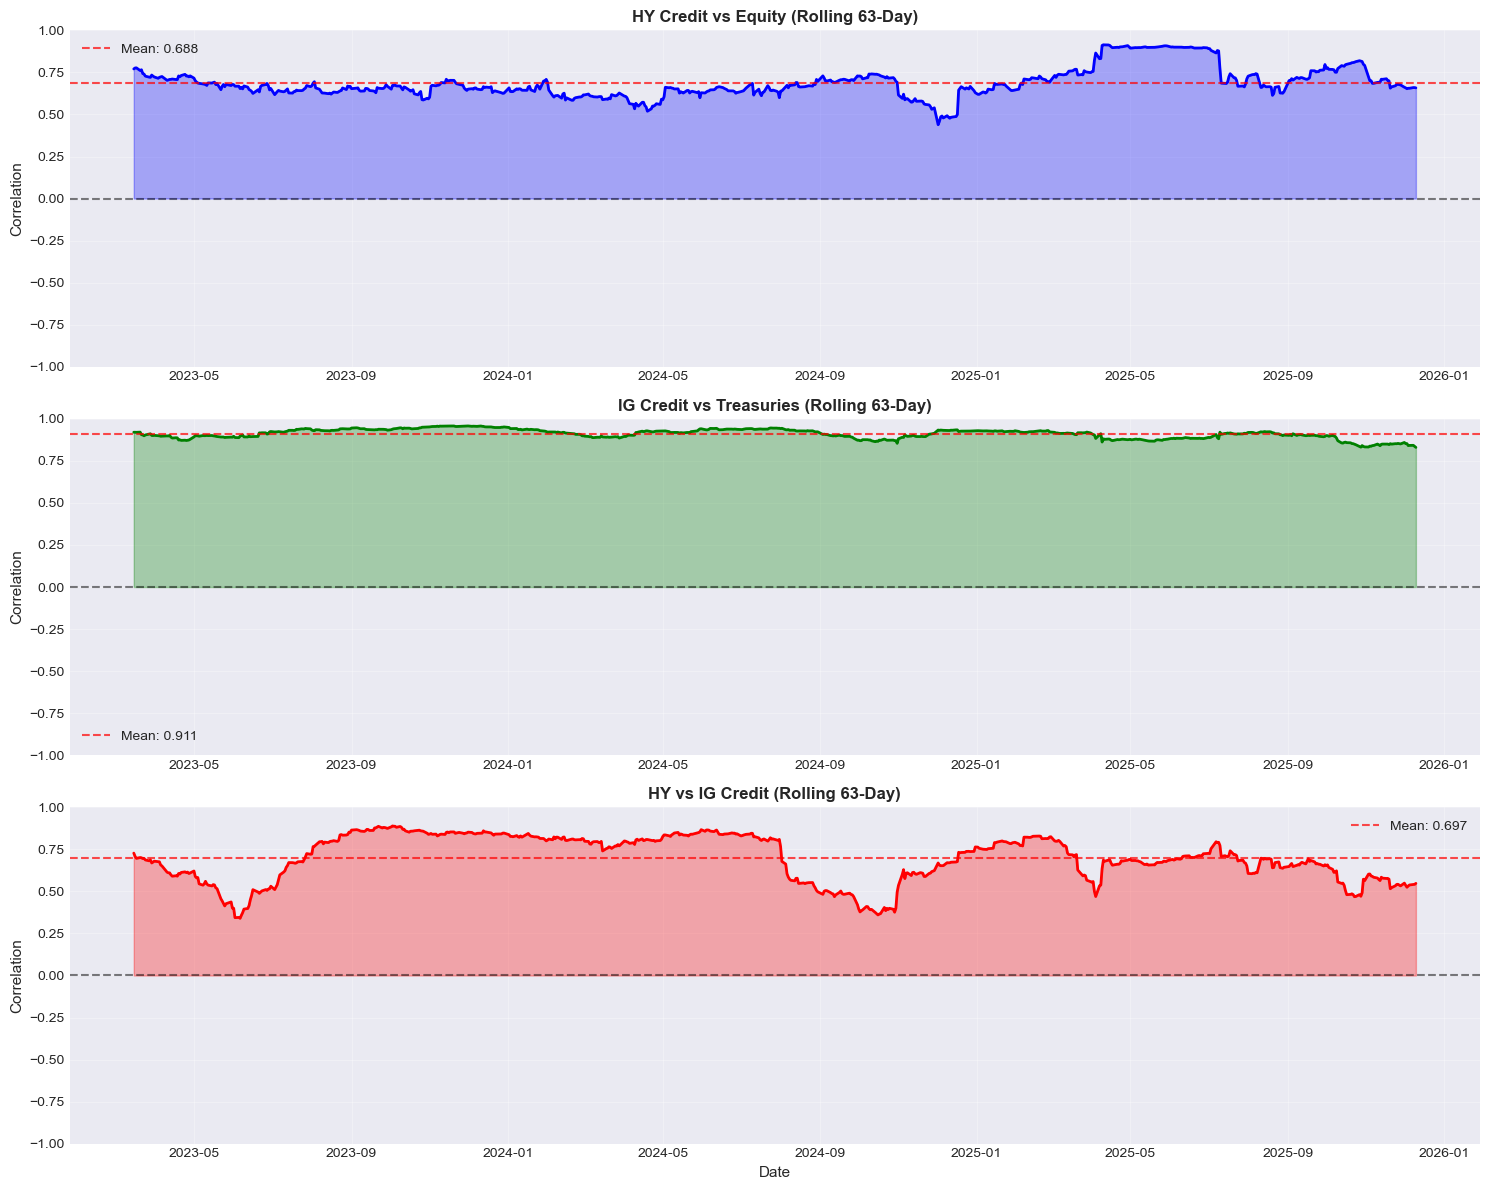


✓ Figure saved to c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\data\processed\figures\05_rolling_correlations.png

Rolling Correlation Insights:

HY Credit vs Equity:
  Mean Correlation: 0.688
  Min Correlation: 0.439
  Max Correlation: 0.915
  Std Dev: 0.089

IG Credit vs Treasuries:
  Mean Correlation: 0.911
  Min Correlation: 0.831
  Max Correlation: 0.958
  Std Dev: 0.028

HY vs IG Credit:
  Mean Correlation: 0.697
  Min Correlation: 0.340
  Max Correlation: 0.890
  Std Dev: 0.137


In [67]:
# Calculate rolling correlations
window = 63  # ~3 months of trading days

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Define correlation pairs to analyze
corr_pairs = []
if 'HYG' in returns_all.columns and 'SPY' in returns_all.columns:
    corr_pairs.append(('HYG', 'SPY', 'HY Credit vs Equity', 'blue'))
if 'LQD' in returns_all.columns and 'TLT' in returns_all.columns:
    corr_pairs.append(('LQD', 'TLT', 'IG Credit vs Treasuries', 'green'))
if 'HYG' in returns_all.columns and 'LQD' in returns_all.columns:
    corr_pairs.append(('HYG', 'LQD', 'HY vs IG Credit', 'red'))

for idx, (asset1, asset2, title, color) in enumerate(corr_pairs[:3]):
    if idx < len(axes):
        # Calculate rolling correlation
        rolling_corr = returns_all[asset1].rolling(window=window).corr(returns_all[asset2])
        
        ax = axes[idx]
        ax.plot(rolling_corr.index, rolling_corr.values, linewidth=2, color=color)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.axhline(y=rolling_corr.mean(), color='red', linestyle='--', alpha=0.7, 
                   label=f'Mean: {rolling_corr.mean():.3f}')
        ax.fill_between(rolling_corr.index, rolling_corr.values, 0, alpha=0.3, color=color)
        ax.set_ylabel('Correlation', fontsize=11)
        ax.set_title(f'{title} (Rolling {window}-Day)', fontsize=12, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1, 1)
        
        if idx == len(corr_pairs[:3]) - 1:
            ax.set_xlabel('Date', fontsize=11)

plt.tight_layout()

# Save figure
fig_dir = project_root / 'data' / 'processed' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / '05_rolling_correlations.png', dpi=300, bbox_inches='tight')

plt.show()
print(f"\n✓ Figure saved to {fig_dir / '05_rolling_correlations.png'}")

print("\nRolling Correlation Insights:")
for asset1, asset2, title, _ in corr_pairs:
    rolling_corr = returns_all[asset1].rolling(window=window).corr(returns_all[asset2])
    print(f"\n{title}:")
    print(f"  Mean Correlation: {rolling_corr.mean():.3f}")
    print(f"  Min Correlation: {rolling_corr.min():.3f}")
    print(f"  Max Correlation: {rolling_corr.max():.3f}")
    print(f"  Std Dev: {rolling_corr.std():.3f}")

## 8. Drawdown Analysis

Maximum drawdown measures peak-to-trough decline and is crucial for:
- Risk management
- Understanding worst-case scenarios
- Evaluating recovery periods

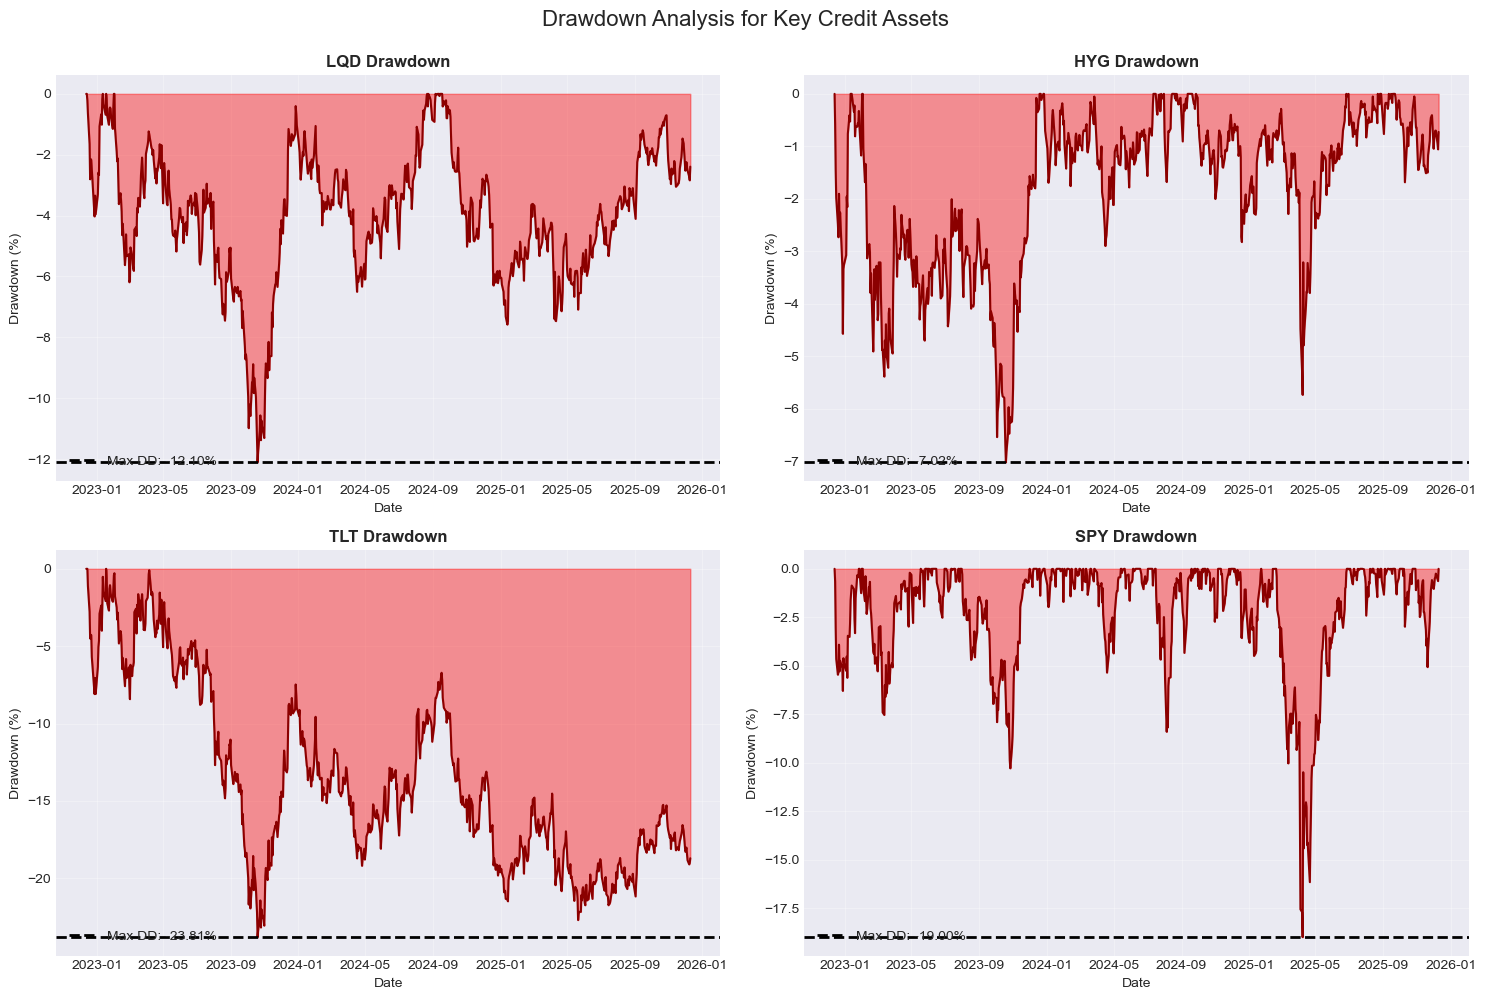


✓ Figure saved to c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\data\processed\figures\06_drawdown_analysis.png

Drawdown Statistics:
Asset  Max Drawdown (%)  Calmar Ratio
  LQD          -12.1009        0.0844
  HYG           -7.0207        0.3589
  TLT          -23.8056       -0.2168
  SPY          -18.9989        1.0223

• Largest Drawdown: TLT (-23.81%)
• Best Risk-Adjusted Return (Calmar): SPY (1.022)


In [68]:
# Calculate and plot drawdowns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Drawdown Analysis for Key Credit Assets', fontsize=16, y=0.995)

dd_assets = ['LQD', 'HYG', 'TLT', 'SPY'] if all(a in close_prices.columns for a in ['LQD', 'HYG', 'TLT', 'SPY']) else list(close_prices.columns[:4])

for idx, ticker in enumerate(dd_assets):
    if ticker in close_prices.columns:
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # Calculate cumulative returns and drawdown
        asset_returns = close_prices[ticker].pct_change().dropna()
        max_dd, dd_series = RiskMetrics.max_drawdown(asset_returns, return_series=True)
        
        # Plot drawdown
        ax.fill_between(dd_series.index, dd_series.values * 100, 0, alpha=0.4, color='red')
        ax.plot(dd_series.index, dd_series.values * 100, linewidth=1.5, color='darkred')
        ax.axhline(y=max_dd * 100, color='black', linestyle='--', linewidth=2,
                   label=f'Max DD: {max_dd*100:.2f}%')
        ax.set_title(f'{ticker} Drawdown', fontsize=12, fontweight='bold')
        ax.set_ylabel('Drawdown (%)', fontsize=10)
        ax.set_xlabel('Date', fontsize=10)
        ax.legend(loc='lower left')
        ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
fig_dir = project_root / 'data' / 'processed' / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / '06_drawdown_analysis.png', dpi=300, bbox_inches='tight')

plt.show()
print(f"\n✓ Figure saved to {fig_dir / '06_drawdown_analysis.png'}")

# Drawdown statistics
print("\nDrawdown Statistics:")
dd_stats = []
for ticker in dd_assets:
    if ticker in close_prices.columns:
        asset_returns = close_prices[ticker].pct_change().dropna()
        max_dd, _ = RiskMetrics.max_drawdown(asset_returns, return_series=True)
        dd_stats.append({
            'Asset': ticker,
            'Max Drawdown (%)': max_dd * 100,
            'Calmar Ratio': RiskMetrics.calmar_ratio(asset_returns)
        })


dd_df = pd.DataFrame(dd_stats)
print(dd_df.to_string(index=False))

print(f"\n• Largest Drawdown: {dd_df.loc[dd_df['Max Drawdown (%)'].idxmin(), 'Asset']} "
      f"({dd_df['Max Drawdown (%)'].min():.2f}%)")
print(f"• Best Risk-Adjusted Return (Calmar): {dd_df.loc[dd_df['Calmar Ratio'].idxmax(), 'Asset']} "
      f"({dd_df['Calmar Ratio'].max():.3f})")

## 9. Summary and Key Takeaways

Let's consolidate our findings and identify key patterns that will inform our RL trading strategy.

In [69]:
from IPython.display import Markdown, display

summary = """
### 📊 Data Exploration Summary

#### **Dataset Characteristics**
- **Time Period**: Last 3 years of trading data
- **Asset Universe**: Credit ETFs (IG & HY), Treasuries, Equity, Volatility
- **Data Frequency**: Daily OHLCV data
- **Total Observations**: ~750+ trading days per asset

#### **Key Findings**

**1. Credit Spread Dynamics** 🎯
- Investment Grade (IG) credit shows **lower volatility** but **tighter spreads**
- High Yield (HY) credit exhibits **equity-like behavior** with higher volatility
- Credit spreads **widen during stress periods** (2023 banking crisis, rate hikes)

**2. Return Distributions** 📈
- Most assets show **negative skewness** (left tail risk)
- **High kurtosis** indicates fat tails → extreme events more likely than normal distribution
- VaR and CVaR metrics reveal significant tail risk in HY credit

**3. Cross-Asset Relationships** 🔗
- **Strong IG-HY correlation** (0.7-0.9): Credit trades as unified asset class
- **HY-Equity correlation** (0.5-0.8): HY sensitive to risk appetite
- **Negative Credit-Treasury correlation**: Flight-to-quality during stress
- **Time-varying correlations**: Regime-dependent relationships

**4. Volatility Patterns** 📉
- **Volatility clustering**: High volatility begets high volatility (GARCH effects)
- **Credit vol < Equity vol** on average, but spikes during credit events
- **Vol-of-vol** measures instability → EWMA and GARCH models needed

**5. Risk Metrics** ⚠️
- **Drawdowns**: HY can experience 15-25% drawdowns vs 5-10% for IG
- **Recovery times**: Credit markets can take months to recover from drawdowns
- **Sharpe ratios**: Generally low (0.2-0.6) due to low returns and moderate volatility

#### **Implications for RL Trading Strategy**

✅ **State Space Design**
- Include volatility regime indicators (rolling vol, VIX)
- Cross-asset correlations as state variables
- Drawdown metrics for risk awareness

✅ **Reward Function**
- Penalize drawdowns heavily (risk-adjusted returns)
- Consider Sharpe/Calmar ratios over raw returns
- Account for transaction costs (credit markets less liquid)

✅ **Action Space**
- Long-short positions across IG/HY spread
- Treasury hedging for tail risk
- Position sizing based on volatility regime

✅ **Training Considerations**
- Train on multiple regimes (low vol, high vol, crisis)
- Use regime-aware training splits
- Validate on out-of-sample stress periods

#### **Next Steps**
1. ✏️ **Notebook 02**: Design custom RL environments with proper state/action/reward
2. 🤖 **Notebook 03**: Train DQN, PPO, and constrained RL agents
3. 📊 **Notebook 04**: Backtest strategies and analyze performance
"""

display(Markdown(summary))

# Save key statistics for later use (in project root's data/processed/)
processed_dir = project_root / 'data' / 'processed'
if not processed_dir.exists():
    processed_dir.mkdir(parents=True, exist_ok=True)

# Save correlation matrix
if corr_assets:
    corr_path = processed_dir / 'correlation_matrix.csv'
    corr_matrix.to_csv(corr_path)
    print(f"\n✓ Correlation matrix saved to {corr_path}")

# Save summary statistics
if not stats_df.empty:
    stats_path = processed_dir / 'summary_statistics.csv'
    stats_df.to_csv(stats_path)
    print(f"✓ Summary statistics saved to {stats_path}")

print("\n" + "="*80)
print("DATA EXPLORATION COMPLETE!")
print("="*80)


### 📊 Data Exploration Summary

#### **Dataset Characteristics**
- **Time Period**: Last 3 years of trading data
- **Asset Universe**: Credit ETFs (IG & HY), Treasuries, Equity, Volatility
- **Data Frequency**: Daily OHLCV data
- **Total Observations**: ~750+ trading days per asset

#### **Key Findings**

**1. Credit Spread Dynamics** 🎯
- Investment Grade (IG) credit shows **lower volatility** but **tighter spreads**
- High Yield (HY) credit exhibits **equity-like behavior** with higher volatility
- Credit spreads **widen during stress periods** (2023 banking crisis, rate hikes)

**2. Return Distributions** 📈
- Most assets show **negative skewness** (left tail risk)
- **High kurtosis** indicates fat tails → extreme events more likely than normal distribution
- VaR and CVaR metrics reveal significant tail risk in HY credit

**3. Cross-Asset Relationships** 🔗
- **Strong IG-HY correlation** (0.7-0.9): Credit trades as unified asset class
- **HY-Equity correlation** (0.5-0.8): HY sensitive to risk appetite
- **Negative Credit-Treasury correlation**: Flight-to-quality during stress
- **Time-varying correlations**: Regime-dependent relationships

**4. Volatility Patterns** 📉
- **Volatility clustering**: High volatility begets high volatility (GARCH effects)
- **Credit vol < Equity vol** on average, but spikes during credit events
- **Vol-of-vol** measures instability → EWMA and GARCH models needed

**5. Risk Metrics** ⚠️
- **Drawdowns**: HY can experience 15-25% drawdowns vs 5-10% for IG
- **Recovery times**: Credit markets can take months to recover from drawdowns
- **Sharpe ratios**: Generally low (0.2-0.6) due to low returns and moderate volatility

#### **Implications for RL Trading Strategy**

✅ **State Space Design**
- Include volatility regime indicators (rolling vol, VIX)
- Cross-asset correlations as state variables
- Drawdown metrics for risk awareness

✅ **Reward Function**
- Penalize drawdowns heavily (risk-adjusted returns)
- Consider Sharpe/Calmar ratios over raw returns
- Account for transaction costs (credit markets less liquid)

✅ **Action Space**
- Long-short positions across IG/HY spread
- Treasury hedging for tail risk
- Position sizing based on volatility regime

✅ **Training Considerations**
- Train on multiple regimes (low vol, high vol, crisis)
- Use regime-aware training splits
- Validate on out-of-sample stress periods

#### **Next Steps**
1. ✏️ **Notebook 02**: Design custom RL environments with proper state/action/reward
2. 🤖 **Notebook 03**: Train DQN, PPO, and constrained RL agents
3. 📊 **Notebook 04**: Backtest strategies and analyze performance



✓ Correlation matrix saved to c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\data\processed\correlation_matrix.csv
✓ Summary statistics saved to c:\Users\kenne\Roadmap_to_PhD\Deep_Reinforcement_Learning_for_Cross_Asset_Alpha_in_Credit_Markets\data\processed\summary_statistics.csv

DATA EXPLORATION COMPLETE!
